## Course Project: Intro to Machine Learning
__Team Member__: Emma Li, Tiancheng Li

__Dataset__: MIES_Dev

### Preprocessing

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import seaborn as sns

In [2]:
#import data
df = pd.read_table('data.csv')

In [3]:
# data preview
df.head()

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,Q91E,country,dateload,introelapse,testelapse,surveyelapse,gender,engnat,age,IE
0,5,51,7107,3,91,2522,1,56,6180,2,...,4609,US,2019-02-20 17:35:52,1,461,16,2,1,23,3
1,5,39,6354,5,13,3092,1,12,5243,5,...,10409,AU,2019-02-20 17:46:32,21,467,15,1,2,25,2
2,3,17,5397,4,35,2747,5,40,5262,3,...,2691,BR,2019-02-20 18:10:24,56,306,17,1,2,19,1
3,5,41,3055,2,14,3348,1,13,5141,1,...,3697,CZ,2019-02-20 18:16:21,2,287,14,1,1,23,1
4,1,76,2542,2,54,1878,1,15,5637,1,...,1662,CA,2019-02-20 18:21:49,2,325,12,1,1,18,2


In [4]:
# drop na.
df.dropna(inplace=True)
df.shape

(7186, 282)

In [5]:
# data preprocessing
df = df.drop(['country', 'dateload', 'introelapse', 'testelapse',
              'surveyelapse', 'gender', 'engnat', 'age'], axis=1)

In [6]:
df.shape

(7186, 274)

In [7]:
# only keep rows where IE =1/2
df = df[(df.IE == 2) | (df.IE == 1)]
df.head()

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,Q89A,Q89I,Q89E,Q90A,Q90I,Q90E,Q91A,Q91I,Q91E,IE
1,5,39,6354,5,13,3092,1,12,5243,5,...,4,90,2827,4,28,3884,3,1,10409,2
2,3,17,5397,4,35,2747,5,40,5262,3,...,2,41,3337,1,87,1759,1,19,2691,1
3,5,41,3055,2,14,3348,1,13,5141,1,...,4,40,3198,3,15,2345,3,23,3697,1
4,1,76,2542,2,54,1878,1,15,5637,1,...,5,7,4024,5,86,6413,5,69,1662,2
5,2,77,1455,5,75,1864,5,34,5235,1,...,2,10,2691,2,47,14032,2,62,5858,1


In [8]:
# drop IE
IE = df['IE']  # label
df = df.drop(['IE'], axis=1)
df.shape

(5393, 273)

In [9]:
# drop values in 'I','E'
df = df.iloc[:, 0:273:3]
print(df.shape)
df.head()

(5393, 91)


,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,Q82A,Q83A,Q84A,Q85A,Q86A,Q87A,Q88A,Q89A,Q90A,Q91A
1,5,5,1,5,2,2,5,2,1,3,...,1,2,2,2,1,3,4,4,4,3
2,3,4,5,3,4,5,5,5,5,5,...,5,5,5,5,4,5,3,2,1,1
3,5,2,1,1,5,5,5,4,4,2,...,5,5,5,5,3,5,4,4,3,3
4,1,2,1,1,3,3,5,1,3,4,...,2,3,1,1,3,1,2,5,5,5
5,2,5,5,1,2,4,5,2,4,4,...,2,2,3,1,3,1,2,2,2,2


### PCA

In [10]:
# PCA
pca = PCA()
principalComponents = pca.fit_transform(df)

Text(0.5, 1, 'PCA Analysis')

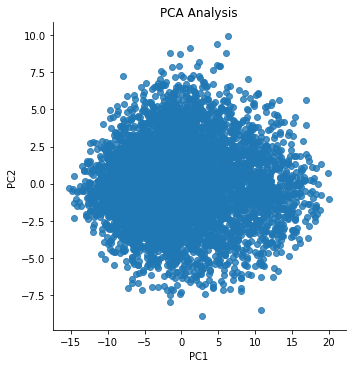

In [11]:
# 2 PCs
principalDf = pd.DataFrame(
    data=principalComponents[:, 0:2], columns=['PC1', 'PC2'])
sns.lmplot(x='PC1', y='PC2', data=principalDf, fit_reg=False)
plt.title('PCA Analysis')

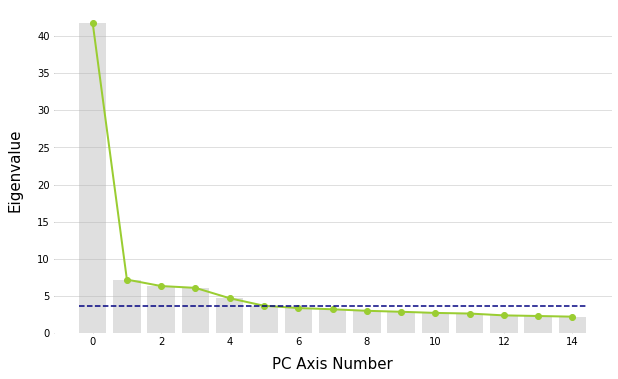

In [12]:
%matplotlib inline
plt.figure(figsize=[10, 6])  # set fig size
ax = plt.gca()
plt.bar(x=np.arange(15),
        height=pca.explained_variance_[0:15], color='silver', alpha=.5)  # only plot the first 15 PCs
plt.plot(pca.explained_variance_[0:15], '-o', color='yellowgreen', linewidth=2)

plt.xlabel('PC Axis Number', fontsize=15, labelpad=10)
plt.ylabel('Eigenvalue', fontsize=15, labelpad=15)
plt.grid(axis='y', alpha=.5)
plt.hlines(y=pca.explained_variance_[5], xmin=plt.xlim()[0] + .75, xmax=plt.xlim()[1] - .75,
           color='navy', linestyles='dashed', linewidth=1.5, zorder=10)  # cut-off line

# hide grid and ticks
for i in ['top', 'bottom', 'left', 'right']:
    ax.spines[i].set_visible(False)
ax.tick_params(axis=u'both', which=u'both', length=0.1)

*We chose the first <font color = 'blue'>6 PCs </font>following "the elbow rule" since the eigenvalue appears to level off at that point*

## Logistic Regression

In [13]:
df_select = principalComponents[:, 0:6]  # select the first 6 PCs
X_train, X_test, y_train, y_test = train_test_split(
    df_select, IE, random_state=0)  # split data

In [14]:
# cross-val to select parameters: C and penalty
lg = LogisticRegression(random_state=0)
params = [{'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]}]
cv = 5
logCV = GridSearchCV(lg, cv=cv, param_grid=params, scoring='roc_auc')
logCV.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10.0, 100.0]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [15]:
print('Grid best parameters are', logCV.best_params_)
print('Grid best auc score is', logCV.best_score_)
print('Baseline accuracy for the training set is',
      np.max(y_train.value_counts()/len(y_train)))

Grid best parameters are {'C': 0.01}
Grid best auc score is 0.9666096000664173
Baseline accuracy for the training set is 0.814540059347181


In [16]:
y_decision = logCV.decision_function(X_test)  # fit test set
print('AUC score for the test set is', roc_auc_score(y_test, y_decision))
print('Baseline accuracy for the test set is',
      np.max(y_test.value_counts()/len(y_test)))

AUC score for the test set is 0.962030231067888
Baseline accuracy for the test set is 0.8228317272053373


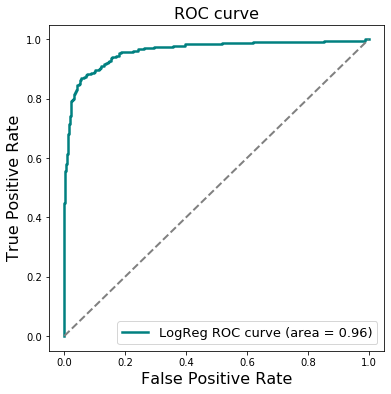

In [18]:
# plot auc
fpr_lg, tpr_lg, _ = roc_curve(y_test, y_decision, pos_label=2)

%matplotlib inline
plt.figure(figsize=[6, 6])
ax2 = plt.gca()
plt.plot(fpr_lg, tpr_lg, lw=2.5, color='teal',
         label='LogReg ROC curve (area = {:0.2f})'.format(roc_auc_score(y_test, y_decision)))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')